# Dependencies & Variables

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

In [ ]:
dh1 = [21,6,7,8]		# What is the first dihedral?
dh2 = [20,12,13,14]		# What is the second dihedral?
itp_file_path = '3mer_lpg.itp'
n = 4

# Extend Mol.itp

### Parse Mol.itp & Identify 'nmer'

In [ ]:
def parse_itp_file(file_path):
    data = {}
    current_section = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(';') or not line:
                continue
            elif line.startswith('[') and line.endswith(']'):
                current_section = line[1:-1].strip()
                data[current_section] = []
                if current_section in ['angles', 'moleculetype', 'atoms']:
                    next(file)  # Skip one line for certain sections
            else:
                line_data = line.split(';')[0].strip()
                if line_data:
                    if current_section == 'dihedrals':
                        if 'IMPROPER DIHEDRAL' in line_data:
                            next(file)  # Skip the next line for improper dihedrals
                            continue
                        elif 'PROPER DIHEDRAL' in line_data:
                            next(file)  # Skip the next line for proper dihedrals
                            continue
                    data[current_section].append(line_data.split())
    return data

def process_dihedrals_sections(file_path):
    improper_data = []
    proper_data = []
    with open(file_path, 'r') as file:
        section_flag = None  # Tracks the current section
        dihedrals_flag = False  # Flag to indicate dihedrals section
        section_type = None  # Tracks the type of dihedrals section
        for line in file:
            line = line.strip()
            if line.startswith('[ dihedrals ]'):
                dihedrals_flag = True
            elif dihedrals_flag and line.startswith('; IMPROPER DIHEDRAL ANGLES'):
                section_flag = 'improper'
                section_type = 'Improper Dihedrals'
            elif dihedrals_flag and line.startswith('; PROPER DIHEDRAL ANGLES'):
                section_flag = 'proper'
                section_type = 'Proper Dihedrals'
            elif '[ pairs ]' in line:
                break  # Stop collecting data after encountering [ pairs ]
            elif section_flag == 'improper' and line.strip() and not line.startswith(';'):
                improper_data.append(line.split())
            elif section_flag == 'proper' and line.strip() and not line.startswith(';'):
                proper_data.append(line.split())

    # Convert data to dataframes
    df_improper = pd.DataFrame(improper_data, columns=['ai', 'aj', 'ak', 'al', 'funct', 'c0', 'c1', 'c2'])
    df_proper = pd.DataFrame(proper_data, columns=['ai', 'aj', 'ak', 'al', 'funct', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5'])

    return df_improper, df_proper

def update_nmer_using_graph(df_atoms, df_bonds, dihedral_centers):
    G = nx.Graph()

    # Add edges from bonds
    for _, row in df_bonds.iterrows():
        G.add_edge(int(row['ai']), int(row['aj']))

    # Identify components
    for dihedral_center in dihedral_centers:
        G.remove_edge(dihedral_center[0], dihedral_center[1])

    components = list(nx.connected_components(G))
    atom_to_nmer = {}
    for nmer, component in enumerate(components, start=1):
        for atom in component:
            atom_to_nmer[atom] = nmer

    # Update nmer in df_atoms
    df_atoms['nmer'] = df_atoms['nr'].astype(int).map(atom_to_nmer)

    return df_atoms

# Example usage

dihedral_centers = [(dh1[1], dh1[2]), (dh2[1], dh2[2])]
parsed_data = parse_itp_file(itp_file_path)
df_improper, df_proper = process_dihedrals_sections(itp_file_path)

# Convert each section to a DataFrame
df_atomtypes = pd.DataFrame(parsed_data.get('atomtypes', []), columns=['type', 'type_name', 'mass', 'charge', 'element', 'sigma', 'epsilon'])
df_moleculetype = pd.DataFrame(parsed_data.get('moleculetype', []), columns=['name', 'nrexcl'])
df_atoms = pd.DataFrame(parsed_data.get('atoms', []), columns=['nr', 'type', 'resnr', 'residue', 'atom', 'cgnr', 'charge', 'mass'])
df_bonds = pd.DataFrame(parsed_data.get('bonds', []), columns=['ai', 'aj', 'funct', 'c0', 'c1'])
df_angles = pd.DataFrame(parsed_data.get('angles', []), columns=['ai', 'aj', 'ak', 'funct', 'c0', 'c1'])
df_pairs = pd.DataFrame(parsed_data.get('pairs', []), columns=['ai', 'aj', 'funct'])

df_atoms = update_nmer_using_graph(df_atoms, df_bonds, dihedral_centers)

# Print the DataFrames
print("DataFrame df_atomtypes:")
print(df_atomtypes)

print("\nDataFrame df_moleculetype:")
print(df_moleculetype)

print("\nDataFrame df_atoms:")
print(df_atoms)

print("\nDataFrame df_bonds:")
print(df_bonds)

print("\nDataFrame df_angles:")
print(df_angles)

print("\nDataFrame df_pairs:")
print(df_pairs)

print("\nDataFrame df_improper:")
print(df_improper)

print("\nDataFrame df_proper:")
print(df_proper)


DataFrame df_atomtypes:
        type type_name     mass charge element        sigma      epsilon
0   opls_826      H826   1.0080  0.000       A  2.42000E-01  1.25520E-01
1   opls_811      C811  12.0110  0.000       A  3.55000E-01  2.92880E-01
2   opls_810      C810  12.0110  0.000       A  3.55000E-01  2.92880E-01
3   opls_817      C817  12.0110  0.000       A  3.55000E-01  2.92880E-01
4   opls_800      O800  15.9990  0.000       A  3.12000E-01  7.11280E-01
5   opls_823      H823   1.0080  0.000       A  2.42000E-01  1.25520E-01
6   opls_814      C814  12.0110  0.000       A  3.55000E-01  2.92880E-01
7   opls_812      O812  15.9990  0.000       A  2.90000E-01  5.85760E-01
8   opls_833      H833   1.0080  0.000       A  2.42000E-01  1.25520E-01
9   opls_806      O806  15.9990  0.000       A  2.90000E-01  5.85760E-01
10  opls_818      C818  12.0110  0.000       A  3.55000E-01  2.92880E-01
11  opls_816      C816  12.0110  0.000       A  3.55000E-01  2.92880E-01
12  opls_809      C809  12.

In [ ]:
def assign_nmer_columns(df_atoms, df_bonds, df_angles, df_improper, df_proper):
    # Ensure the columns in df_atoms are integers
    df_atoms['nr'] = df_atoms['nr'].astype(int)
    df_atoms['nmer'] = df_atoms['nmer'].astype(int)

    # Create a mapping of atom number to nmer value
    atom_to_nmer = df_atoms.set_index('nr')['nmer'].to_dict()

    # Ensure the columns in other DataFrames are integers
    df_bonds[['ai', 'aj']] = df_bonds[['ai', 'aj']].astype(int)
    df_angles[['ai', 'aj', 'ak']] = df_angles[['ai', 'aj', 'ak']].astype(int)
    df_improper[['ai', 'aj', 'ak', 'al']] = df_improper[['ai', 'aj', 'ak', 'al']].astype(int)
    df_proper[['ai', 'aj', 'ak', 'al']] = df_proper[['ai', 'aj', 'ak', 'al']].astype(int)

    # Helper function to map nmer values to the respective columns
    def map_nmer(df, columns):
        for col in columns:
            nmer_col = 'nmer_' + col
            df[nmer_col] = df[col].map(atom_to_nmer)
        return df

    # Assign nmer values to df_bonds
    df_bonds = map_nmer(df_bonds, ['ai', 'aj'])

    # Assign nmer values to df_angles
    df_angles = map_nmer(df_angles, ['ai', 'aj', 'ak'])

    # Assign nmer values to df_improper
    df_improper = map_nmer(df_improper, ['ai', 'aj', 'ak', 'al'])

    # Assign nmer values to df_proper
    df_proper = map_nmer(df_proper, ['ai', 'aj', 'ak', 'al'])

    return df_bonds, df_angles, df_improper, df_proper

# Debugging step to print mappings and verify data
print("\nSample df_atoms:")
print(df_atoms)

print("\nSample df_bonds before mapping:")
print(df_bonds)

df_bonds, df_angles, df_improper, df_proper = assign_nmer_columns(df_atoms, df_bonds, df_angles, df_improper, df_proper)

print("\nSample df_bonds after mapping:")
print(df_bonds)

print("\nSample df_angles after mapping:")
print(df_angles)

print("\nSample df_improper after mapping:")
print(df_improper)

print("\nSample df_proper after mapping:")
print(df_proper)


Sample df_atoms:
    nr      type resnr residue atom cgnr   charge     mass  nmer
0    1  opls_800     1     UNK  O00    1  -0.4952  15.9990     1
1    2  opls_801     1     UNK  C01    1   0.1661  12.0110     1
2    3  opls_802     1     UNK  C02    1  -0.2764  12.0110     1
3    4  opls_803     1     UNK  C03    1  -0.0744  12.0110     1
4    5  opls_804     1     UNK  C04    1  -0.2100  12.0110     1
5    6  opls_805     1     UNK  C05    1   0.1625  12.0110     1
6    7  opls_806     1     UNK  O06    1  -0.2457  15.9990     2
7    8  opls_807     1     UNK  C07    1   0.1379  12.0110     2
8    9  opls_808     1     UNK  C08    1  -0.1829  12.0110     2
9   10  opls_809     1     UNK  C09    1  -0.0987  12.0110     2
10  11  opls_810     1     UNK  C0A    1  -0.2173  12.0110     2
11  12  opls_811     1     UNK  C0B    1   0.1435  12.0110     2
12  13  opls_812     1     UNK  O0C    1  -0.2526  15.9990     3
13  14  opls_813     1     UNK  C0D    1   0.1200  12.0110     3
14  15 

In [ ]:
atomic_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

def split_atom_name(df):
    atom_col = []
    atom_namnum_col = []

    for atom_name in df['atom']:
        atom = None
        atom_namnum = None

        # Check if the atom name starts with an atomic symbol
        for symbol in atomic_symbols:
            if atom_name.startswith(symbol):
                # Check if there are additional characters after the atomic symbol
                if len(atom_name) > len(symbol):
                    next_char = atom_name[len(symbol)]
                    if next_char.isdigit() or (next_char.isalpha() and next_char.isupper()):
                        atom = symbol
                        atom_namnum = atom_name[len(symbol):]
                        break
                    elif next_char.isalpha() and next_char.islower():
                        # Check if the full atom name matches any atomic symbol
                        if atom_name in atomic_symbols:
                            atom = atom_name
                            break

        if atom is None:
            raise ValueError(f"Atomic symbol not found in atom_name: {atom_name}")

        atom_col.append(atom)
        atom_namnum_col.append(atom_namnum)

    df['atom_type'] = atom_col  # Create new column for atom type
    df['atom_namnum'] = atom_namnum_col  # Create new column for name/number part

    return df

# Function to map atom types based on the atom number
def map_atom_types(df_atoms, df, columns):
    atom_to_type = df_atoms.set_index('nr')['atom_type'].to_dict()

    for col in columns:
        atom_col = 'atom_' + col  # Create new column name
        df[atom_col] = df[col].map(atom_to_type)  # Map atom type using atom number

    return df

# Apply split_atom_name to df_atoms
df_atoms = split_atom_name(df_atoms)

# Now map atom types to df_bonds, df_angles, df_improper, df_proper
df_bonds = map_atom_types(df_atoms, df_bonds, ['ai', 'aj'])
df_angles = map_atom_types(df_atoms, df_angles, ['ai', 'aj', 'ak'])
df_improper = map_atom_types(df_atoms, df_improper, ['ai', 'aj', 'ak', 'al'])
df_proper = map_atom_types(df_atoms, df_proper, ['ai', 'aj', 'ak', 'al'])

# Print the updated dataframes
print("Updated df_atoms:")
print(df_atoms)

print("Updated df_bonds:")
print(df_bonds)

print("Updated df_angles:")
print(df_angles)

print("Updated df_improper:")
print(df_improper)

print("Updated df_proper:")
print(df_proper)

Updated df_atoms:
    nr      type resnr residue atom cgnr   charge     mass  nmer atom_type  \
0    1  opls_800     1     UNK  O00    1  -0.4952  15.9990     1         O   
1    2  opls_801     1     UNK  C01    1   0.1661  12.0110     1         C   
2    3  opls_802     1     UNK  C02    1  -0.2764  12.0110     1         C   
3    4  opls_803     1     UNK  C03    1  -0.0744  12.0110     1         C   
4    5  opls_804     1     UNK  C04    1  -0.2100  12.0110     1         C   
5    6  opls_805     1     UNK  C05    1   0.1625  12.0110     1         C   
6    7  opls_806     1     UNK  O06    1  -0.2457  15.9990     2         O   
7    8  opls_807     1     UNK  C07    1   0.1379  12.0110     2         C   
8    9  opls_808     1     UNK  C08    1  -0.1829  12.0110     2         C   
9   10  opls_809     1     UNK  C09    1  -0.0987  12.0110     2         C   
10  11  opls_810     1     UNK  C0A    1  -0.2173  12.0110     2         C   
11  12  opls_811     1     UNK  C0B    1   0.1

#### Check 'nmer' Was Correctly Identified

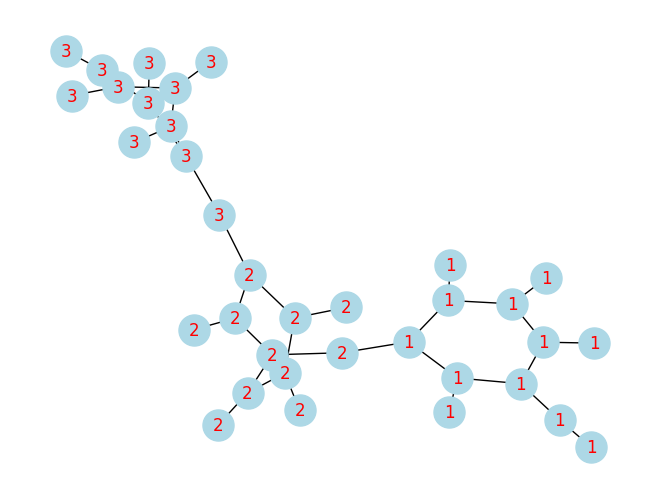

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph_from_bonds(df_bonds):
    # Create a new graph
    G = nx.Graph()

    # Add edges based on the ai and aj columns
    for _, row in df_bonds.iterrows():
        ai, aj = row['ai'], row['aj']
        nmer_ai, nmer_aj = row['nmer_ai'], row['nmer_aj']

        # Add edges between ai and aj
        G.add_edge(ai, aj)

        # Add the nmer value as a label to the nodes
        G.nodes[ai]['nmer'] = nmer_ai
        G.nodes[aj]['nmer'] = nmer_aj

    # Draw the graph with labels for each node
    pos = nx.spring_layout(G)  # Position the nodes
    labels = nx.get_node_attributes(G, 'nmer')  # Get the nmer labels
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=10)
    nx.draw_networkx_labels(G, pos, labels=labels, font_color='red', font_size=12)

    # Show the graph
    plt.show()

# Call the function with your dataframe
create_graph_from_bonds(df_bonds)


### Renumbering Units

In [ ]:
# Create df_renumber from df_atoms
df_renumber = df_atoms[['nmer', 'nr']].copy()

# Rename 'nr' to 'nr_original'
df_renumber.rename(columns={'nr': 'nr_original'}, inplace=True)

# Add the empty 'nr_renumbered' column
df_renumber['nr_renumbered'] = None

# Reorder df_renumber based on the 'nmer' column (least to greatest)
df_renumber = df_renumber.sort_values(by='nmer', ascending=True).reset_index(drop=True)

# Calculate the total number of rows where nmer = 1
start_size = df_renumber[df_renumber['nmer'] == 1].shape[0]

# Calculate the total number of rows where nmer = 2
mid_size = df_renumber[df_renumber['nmer'] == 2].shape[0]

# Optionally, display the new dataframe
print(df_renumber)

    nmer  nr_original nr_renumbered
0      1            1          None
1      1           25          None
2      1           24          None
3      1           23          None
4      1           22          None
5      1           21          None
6      1           35          None
7      1            6          None
8      1            2          None
9      1            3          None
10     1            4          None
11     1            5          None
12     2           28          None
13     2           27          None
14     2           26          None
15     2            7          None
16     2           20          None
17     2            8          None
18     2           10          None
19     2           12          None
20     2           11          None
21     2           34          None
22     2            9          None
23     3           33          None
24     3           32          None
25     3           31          None
26     3           30       

#### Renumber Start Unit

In [ ]:
# Step 1: Filter df_bonds for rows where both nmer_ai and nmer_aj are 1
dbs = df_bonds[(df_bonds['nmer_ai'] == 1) & (df_bonds['nmer_aj'] == 1)].copy()

# Step 2: Build a graph from the filtered df_bonds data
G = nx.Graph()
for _, row in dbs.iterrows():
    G.add_edge(row['ai'], row['aj'])

# Step 3: Perform a BFS renumbering (starting from an arbitrary node, e.g., the smallest node)
start_node = min(G.nodes())  # Choose the smallest node as the starting point
bfs_order = list(nx.bfs_tree(G, source=start_node))  # Perform BFS and get the BFS order

# Step 4: Create a mapping from original node numbers to BFS order numbers
bfs_mapping = {original: new for new, original in enumerate(bfs_order, start=1)}

# Step 5: Update the df_renumber DataFrame
# For each 'nr_original' that is part of the BFS renumbering, update 'nr_renumbered'
df_renumber.loc[df_renumber['nr_original'].isin(bfs_mapping.keys()), 'nr_renumbered'] = \
    df_renumber['nr_original'].map(bfs_mapping)

# Step 6: Ensure that the 'nr_renumbered' column is integer type
df_renumber['nr_renumbered'] = df_renumber['nr_renumbered'].astype('Int64')

# Optionally, display the updated df_renumber
print(df_renumber)

    nmer  nr_original  nr_renumbered
0      1            1              1
1      1           25             12
2      1           24             11
3      1           23              7
4      1           22              3
5      1           21              5
6      1           35              8
7      1            6              9
8      1            2              2
9      1            3              4
10     1            4              6
11     1            5             10
12     2           28           <NA>
13     2           27           <NA>
14     2           26           <NA>
15     2            7           <NA>
16     2           20           <NA>
17     2            8           <NA>
18     2           10           <NA>
19     2           12           <NA>
20     2           11           <NA>
21     2           34           <NA>
22     2            9           <NA>
23     3           33           <NA>
24     3           32           <NA>
25     3           31           <NA>
2

#### Renumber End Unit

In [ ]:
# Step 1: Filter df_bonds for rows where both nmer_ai and nmer_aj are 3
df_bonds_start = df_bonds[(df_bonds['nmer_ai'] == 3) & (df_bonds['nmer_aj'] == 3)].copy()

# Step 2: Build a graph from the filtered df_bonds data
G = nx.Graph()
for _, row in df_bonds_start.iterrows():
    G.add_edge(row['ai'], row['aj'])

# Step 3: Perform a BFS renumbering (starting from an arbitrary node, e.g., the smallest node)
start_node = min(G.nodes())  # Choose the smallest node as the starting point
bfs_order = list(nx.bfs_tree(G, source=start_node))  # Perform BFS and get the BFS order

# Step 4: Create a mapping from original node numbers to BFS order numbers
bfs_mapping = {original: new for new, original in enumerate(bfs_order, start=1)}

# Step 5: Update the df_renumber DataFrame
# For each 'nr_original' that is part of the BFS renumbering, update 'nr_renumbered'
df_renumber.loc[df_renumber['nr_original'].isin(bfs_mapping.keys()), 'nr_renumbered'] = \
    df_renumber['nr_original'].map(bfs_mapping)

# Step 6: Ensure that the 'nr_renumbered' column is integer type
df_renumber['nr_renumbered'] = df_renumber['nr_renumbered'].astype('Int64')

# Step 7: Update the 'nmer' column where 'nmer' equals 3 to the value of 'n'
df_renumber.loc[df_renumber['nmer'] == 3, 'nmer'] = n

# Optionally, display the updated df_renumber
print(df_renumber)

    nmer  nr_original  nr_renumbered
0      1            1              1
1      1           25             12
2      1           24             11
3      1           23              7
4      1           22              3
5      1           21              5
6      1           35              8
7      1            6              9
8      1            2              2
9      1            3              4
10     1            4              6
11     1            5             10
12     2           28           <NA>
13     2           27           <NA>
14     2           26           <NA>
15     2            7           <NA>
16     2           20           <NA>
17     2            8           <NA>
18     2           10           <NA>
19     2           12           <NA>
20     2           11           <NA>
21     2           34           <NA>
22     2            9           <NA>
23    40           33              7
24    40           32             11
25    40           31             12
2

#### Renumber Mid Unit

In [ ]:
# Step 1: Filter df_bonds for rows where both nmer_ai and nmer_aj are 2
dbm = df_bonds[(df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 2)].copy()

# Step 2: Build a graph from the filtered df_bonds data
G = nx.Graph()
for _, row in dbm.iterrows():
    G.add_edge(row['ai'], row['aj'])

# Step 3: Perform a BFS renumbering (starting from an arbitrary node, e.g., the smallest node)
start_node = min(G.nodes())  # Choose the smallest node as the starting point
bfs_order = list(nx.bfs_tree(G, source=start_node))  # Perform BFS and get the BFS order

# Step 4: Create a mapping from original node numbers to BFS order numbers
bfs_mapping = {original: new for new, original in enumerate(bfs_order, start=1)}

# Step 5: Update the df_renumber DataFrame
# For each 'nr_original' that is part of the BFS renumbering, update 'nr_renumbered'
df_renumber.loc[df_renumber['nr_original'].isin(bfs_mapping.keys()), 'nr_renumbered'] = \
    df_renumber['nr_original'].map(bfs_mapping)

# Step 6: Ensure that the 'nr_renumbered' column is integer type
df_renumber['nr_renumbered'] = df_renumber['nr_renumbered'].astype('Int64')

# Step 1: Filter rows where nmer = 2
df_nmer_2 = df_renumber[df_renumber['nmer'] == 2].copy()

# Step 2: Initialize an empty list to store the new rows that will be appended
new_rows = []

# Step 3: Loop from 1 to (n-3)
for i in range(1, n - 2):
    # Copy the rows and increment the 'nmer' value by i
    df_copy = df_nmer_2.copy()
    df_copy['nmer'] = df_copy['nmer'] + i

    # Append these rows to the new_rows list
    new_rows.append(df_copy)

# Step 4: Concatenate the original dataframe with the new rows
if new_rows:  # If there are new rows to append
    df_new_rows = pd.concat(new_rows, ignore_index=True)
    df_renumber = pd.concat([df_renumber, df_new_rows], ignore_index=True)

# Optionally, display the updated df_renumber
print(df_renumber)

     nmer  nr_original  nr_renumbered
0       1            1              1
1       1           25             12
2       1           24             11
3       1           23              7
4       1           22              3
..    ...          ...            ...
437    39           10              5
438    39           12              8
439    39           11              9
440    39           34              7
441    39            9              3

[442 rows x 3 columns]


#### Final Renumbering

In [ ]:
# Step 1: Sort df_renumber by nmer to ensure correct order
df_renumber = df_renumber.sort_values(by='nmer', ascending=True).reset_index(drop=True)

# Step 2: Get the unique nmer values and iterate over them
unique_nmers = df_renumber['nmer'].unique()

for current_nmer in unique_nmers:
    if current_nmer > n:
        break  # Stop when we reach nmer = n

    # Step 3: Count the number of rows with nmer less than the current nmer
    num_rows_less_than_current = df_renumber[df_renumber['nmer'] < current_nmer].shape[0]

    # Step 4: Add this number to the 'nr_renumbered' values for rows with the current nmer
    df_renumber.loc[df_renumber['nmer'] == current_nmer, 'nr_renumbered'] = \
        df_renumber.loc[df_renumber['nmer'] == current_nmer, 'nr_renumbered'] + num_rows_less_than_current

# Optionally, display the updated df_renumber
print(df_renumber)

     nmer  nr_original  nr_renumbered
0       1            1              1
1       1           21              5
2       1           25             12
3       1           24             11
4       1           22              3
..    ...          ...            ...
437    40           32            441
438    40           33            437
439    40           18            438
440    40           29            436
441    40           13            431

[442 rows x 3 columns]


### Separate Units

#### Separate Start Unit

In [ ]:
# Create df_atoms_start from df_atoms where nmer = 1
df_atoms_start = df_atoms[df_atoms['nmer'] == 1].copy()

# Create df_bonds_start from df_bonds where both nmer_ai and nmer_aj are 1
df_bonds_start = df_bonds[(df_bonds['nmer_ai'] == 1) & (df_bonds['nmer_aj'] == 1)].copy()

# Create df_angles_start from df_angles where nmer_ai, nmer_aj, and nmer_ak are all 1
df_angles_start = df_angles[(df_angles['nmer_ai'] == 1) &
                            (df_angles['nmer_aj'] == 1) &
                            (df_angles['nmer_ak'] == 1)].copy()

# Create df_improper_start from df_improper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_improper_start = df_improper[(df_improper['nmer_ai'] == 1) &
                                (df_improper['nmer_aj'] == 1) &
                                (df_improper['nmer_ak'] == 1) &
                                (df_improper['nmer_al'] == 1)].copy()

# Create df_proper_start from df_proper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_proper_start = df_proper[(df_proper['nmer_ai'] == 1) &
                            (df_proper['nmer_aj'] == 1) &
                            (df_proper['nmer_ak'] == 1) &
                            (df_proper['nmer_al'] == 1)].copy()

# Optionally, display the results
print(df_atoms_start)
print(df_bonds_start)
print(df_angles_start)
print(df_improper_start)
print(df_proper_start)

    nr      type resnr residue atom cgnr   charge     mass  nmer atom_type  \
0    1  opls_800     1     UNK  O00    1  -0.4952  15.9990     1         O   
1    2  opls_801     1     UNK  C01    1   0.1661  12.0110     1         C   
2    3  opls_802     1     UNK  C02    1  -0.2764  12.0110     1         C   
3    4  opls_803     1     UNK  C03    1  -0.0744  12.0110     1         C   
4    5  opls_804     1     UNK  C04    1  -0.2100  12.0110     1         C   
5    6  opls_805     1     UNK  C05    1   0.1625  12.0110     1         C   
20  21  opls_820     1     UNK  C0K    1  -0.2486  12.0110     1         C   
21  22  opls_821     1     UNK  H0M    1   0.4310   1.0080     1         H   
22  23  opls_822     1     UNK  H0N    1   0.1536   1.0080     1         H   
23  24  opls_823     1     UNK  H0O    1   0.1586   1.0080     1         H   
24  25  opls_824     1     UNK  H0P    1   0.1688   1.0080     1         H   
34  35  opls_834     1     UNK  H0Z    2   0.1831   1.0080     1

#### Separate End Unit

In [ ]:
# Create df_atoms_end from df_atoms where nmer = 1
df_atoms_end = df_atoms[df_atoms['nmer'] == 3].copy()

# Create df_bonds_end from df_bonds where both nmer_ai and nmer_aj are 1
df_bonds_end = df_bonds[(df_bonds['nmer_ai'] == 3) & (df_bonds['nmer_aj'] == 3)].copy()

# Create df_angles_end from df_angles where nmer_ai, nmer_aj, and nmer_ak are all 1
df_angles_end = df_angles[(df_angles['nmer_ai'] == 3) &
                            (df_angles['nmer_aj'] == 3) &
                            (df_angles['nmer_ak'] == 3)].copy()

# Create df_improper_end from df_improper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_improper_end = df_improper[(df_improper['nmer_ai'] == 3) &
                                (df_improper['nmer_aj'] == 3) &
                                (df_improper['nmer_ak'] == 3) &
                                (df_improper['nmer_al'] == 3)].copy()

# Create df_proper_end from df_proper where nmer_ai, nmer_aj, nmer_ak, and nmer_al are all 1
df_proper_end = df_proper[(df_proper['nmer_ai'] == 3) &
                            (df_proper['nmer_aj'] == 3) &
                            (df_proper['nmer_ak'] == 3) &
                            (df_proper['nmer_al'] == 3)].copy()

# Optionally, display the results
print(df_atoms_end)
print(df_bonds_end)
print(df_angles_end)
print(df_improper_end)
print(df_proper_end)

    nr      type resnr residue atom cgnr   charge     mass  nmer atom_type  \
12  13  opls_812     1     UNK  O0C    1  -0.2526  15.9990     3         O   
13  14  opls_813     1     UNK  C0D    1   0.1200  12.0110     3         C   
14  15  opls_814     1     UNK  C0E    1  -0.1667  12.0110     3         C   
15  16  opls_815     1     UNK  C0F    1  -0.1197  12.0110     3         C   
16  17  opls_816     1     UNK  C0G    1  -0.1725  12.0110     3         C   
17  18  opls_817     1     UNK  C0H    1  -0.1184  12.0110     3         C   
18  19  opls_818     1     UNK  C0I    1  -0.2033  12.0110     3         C   
28  29  opls_828     1     UNK  H0T    1   0.1669   1.0080     3         H   
29  30  opls_829     1     UNK  H0U    1   0.1553   1.0080     3         H   
30  31  opls_830     1     UNK  H0V    1   0.1520   1.0080     3         H   
31  32  opls_831     1     UNK  H0W    1   0.1534   1.0080     3         H   
32  33  opls_832     1     UNK  H0X    2   0.1639   1.0080     3

#### Separate Middle Unit & Connection Params

In [ ]:
# Create df_atoms_mid from df_atoms where nmer = 2
df_atoms_mid = df_atoms[df_atoms['nmer'] == 2].copy()

# Create df_bonds_mid from df_bonds where nmer_ai or nmer_aj is 2
df_bonds_mid = df_bonds[(df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 2)].copy()

# Create df_angles_mid from df_angles where nmer_ai, nmer_aj, or nmer_ak is 2
df_angles_mid = df_angles[(df_angles['nmer_ai'] == 2) &
                          (df_angles['nmer_aj'] == 2) &
                          (df_angles['nmer_ak'] == 2)].copy()

# Create df_improper_mid from df_improper where nmer_ai, nmer_aj, nmer_ak, or nmer_al is 2
df_improper_mid = df_improper[(df_improper['nmer_ai'] == 2) &
                              (df_improper['nmer_aj'] == 2) &
                              (df_improper['nmer_ak'] == 2) &
                              (df_improper['nmer_al'] == 2)].copy()

# Create df_proper_mid from df_proper where nmer_ai, nmer_aj, nmer_ak, or nmer_al is 2
df_proper_mid = df_proper[(df_proper['nmer_ai'] == 2) &
                          (df_proper['nmer_aj'] == 2) &
                          (df_proper['nmer_ak'] == 2) &
                          (df_proper['nmer_al'] == 2)].copy()

# Optionally, display the results
print(df_atoms_mid)
print(df_bonds_mid)
print(df_angles_mid)
print(df_improper_mid)
print(df_proper_mid)

    nr      type resnr residue atom cgnr   charge     mass  nmer atom_type  \
6    7  opls_806     1     UNK  O06    1  -0.2457  15.9990     2         O   
7    8  opls_807     1     UNK  C07    1   0.1379  12.0110     2         C   
8    9  opls_808     1     UNK  C08    1  -0.1829  12.0110     2         C   
9   10  opls_809     1     UNK  C09    1  -0.0987  12.0110     2         C   
10  11  opls_810     1     UNK  C0A    1  -0.2173  12.0110     2         C   
11  12  opls_811     1     UNK  C0B    1   0.1435  12.0110     2         C   
19  20  opls_819     1     UNK  C0J    1  -0.2171  12.0110     2         C   
25  26  opls_825     1     UNK  H0Q    1   0.1692   1.0080     2         H   
26  27  opls_826     1     UNK  H0R    1   0.1612   1.0080     2         H   
27  28  opls_827     1     UNK  H0S    1   0.1679   1.0080     2         H   
33  34  opls_833     1     UNK  H0Y    2   0.1847   1.0080     2         H   

   atom_namnum  
6           06  
7           07  
8           

In [ ]:
# For Bonds: Grab rows where one atom is nmer = 1 and the other is nmer = 2
df_bonds_1_2 = df_bonds[((df_bonds['nmer_ai'] == 1) & (df_bonds['nmer_aj'] == 2)) |
                        ((df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 1))].copy()

# For Angles: Grab rows where at least one atom is nmer = 1 and another is nmer = 2
df_angles_1_2 = df_angles[((df_angles['nmer_ai'] == 1) & ((df_angles['nmer_aj'] == 2) | (df_angles['nmer_ak'] == 2))) |
                          ((df_angles['nmer_aj'] == 1) & ((df_angles['nmer_ai'] == 2) | (df_angles['nmer_ak'] == 2))) |
                          ((df_angles['nmer_ak'] == 1) & ((df_angles['nmer_ai'] == 2) | (df_angles['nmer_aj'] == 2)))].copy()

# For Improper Dihedrals: Same logic, but for four atoms
df_improper_1_2 = df_improper[((df_improper['nmer_ai'] == 1) & ((df_improper['nmer_aj'] == 2) |
                                                                (df_improper['nmer_ak'] == 2) |
                                                                (df_improper['nmer_al'] == 2))) |
                              ((df_improper['nmer_aj'] == 1) & ((df_improper['nmer_ai'] == 2) |
                                                                (df_improper['nmer_ak'] == 2) |
                                                                (df_improper['nmer_al'] == 2))) |
                              ((df_improper['nmer_ak'] == 1) & ((df_improper['nmer_ai'] == 2) |
                                                                (df_improper['nmer_aj'] == 2) |
                                                                (df_improper['nmer_al'] == 2))) |
                              ((df_improper['nmer_al'] == 1) & ((df_improper['nmer_ai'] == 2) |
                                                                (df_improper['nmer_aj'] == 2) |
                                                                (df_improper['nmer_ak'] == 2)))].copy()

# For Proper Dihedrals: Same logic for proper dihedrals
df_proper_1_2 = df_proper[((df_proper['nmer_ai'] == 1) & ((df_proper['nmer_aj'] == 2) |
                                                          (df_proper['nmer_ak'] == 2) |
                                                          (df_proper['nmer_al'] == 2))) |
                          ((df_proper['nmer_aj'] == 1) & ((df_proper['nmer_ai'] == 2) |
                                                          (df_proper['nmer_ak'] == 2) |
                                                          (df_proper['nmer_al'] == 2))) |
                          ((df_proper['nmer_ak'] == 1) & ((df_proper['nmer_ai'] == 2) |
                                                          (df_proper['nmer_aj'] == 2) |
                                                          (df_proper['nmer_al'] == 2))) |
                          ((df_proper['nmer_al'] == 1) & ((df_proper['nmer_ai'] == 2) |
                                                          (df_proper['nmer_aj'] == 2) |
                                                          (df_proper['nmer_ak'] == 2)))].copy()

# Optionally, display the results
print(df_bonds_1_2)
print(df_angles_1_2)
print(df_improper_1_2)
print(df_proper_1_2)

   ai  aj funct      c0          c1  nmer_ai  nmer_aj atom_ai atom_aj
5   7   6     1  0.1364  376560.000        2        1       O       C
    ai  aj  ak funct       c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
4    5   6   7     1  120.000  585.760        1        1        2       C   
5    6   7   8     1  111.000  627.600        1        2        2       C   
55   7   6  21     1  120.000  585.760        2        1        1       O   

   atom_aj atom_ak  
4        C       O  
5        O       C  
55       C       C  
   ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
0  21   6   5   7     4  180.000  10.460  2        1        1        1   

   nmer_al atom_ai atom_aj atom_ak atom_al  
0        2       C       C       C       O  
    ai  aj  ak  al funct      c0     c1       c2      c3      c4     c5  \
26   9   8   7   6     3  12.552  0.000  -12.552  -0.000  -0.000  0.000   
27  20   8   7   6     3  12.552  0.000  -12.552  -0.000  -0.000  0.000   
28 

In [ ]:
# For Bonds: Grab rows where one atom is nmer = 2 and the other is nmer = 3
df_bonds_2_3 = df_bonds[((df_bonds['nmer_ai'] == 2) & (df_bonds['nmer_aj'] == 3)) |
                        ((df_bonds['nmer_ai'] == 3) & (df_bonds['nmer_aj'] == 2))].copy()

# For Angles: Grab rows where at least one atom is nmer = 2 and another is nmer = 3
df_angles_2_3 = df_angles[((df_angles['nmer_ai'] == 2) & ((df_angles['nmer_aj'] == 3) | (df_angles['nmer_ak'] == 3))) |
                          ((df_angles['nmer_aj'] == 2) & ((df_angles['nmer_ai'] == 3) | (df_angles['nmer_ak'] == 3))) |
                          ((df_angles['nmer_ak'] == 2) & ((df_angles['nmer_ai'] == 3) | (df_angles['nmer_aj'] == 3)))].copy()

# For Improper Dihedrals: Same logic, but for four atoms
df_improper_2_3 = df_improper[((df_improper['nmer_ai'] == 2) & ((df_improper['nmer_aj'] == 3) |
                                                                (df_improper['nmer_ak'] == 3) |
                                                                (df_improper['nmer_al'] == 3))) |
                              ((df_improper['nmer_aj'] == 2) & ((df_improper['nmer_ai'] == 3) |
                                                                (df_improper['nmer_ak'] == 3) |
                                                                (df_improper['nmer_al'] == 3))) |
                              ((df_improper['nmer_ak'] == 2) & ((df_improper['nmer_ai'] == 3) |
                                                                (df_improper['nmer_aj'] == 3) |
                                                                (df_improper['nmer_al'] == 3))) |
                              ((df_improper['nmer_al'] == 2) & ((df_improper['nmer_ai'] == 3) |
                                                                (df_improper['nmer_aj'] == 3) |
                                                                (df_improper['nmer_ak'] == 3)))].copy()

# For Proper Dihedrals: Same logic for proper dihedrals
df_proper_2_3 = df_proper[((df_proper['nmer_ai'] == 2) & ((df_proper['nmer_aj'] == 3) |
                                                          (df_proper['nmer_ak'] == 3) |
                                                          (df_proper['nmer_al'] == 3))) |
                          ((df_proper['nmer_aj'] == 2) & ((df_proper['nmer_ai'] == 3) |
                                                          (df_proper['nmer_ak'] == 3) |
                                                          (df_proper['nmer_al'] == 3))) |
                          ((df_proper['nmer_ak'] == 2) & ((df_proper['nmer_ai'] == 3) |
                                                          (df_proper['nmer_aj'] == 3) |
                                                          (df_proper['nmer_al'] == 3))) |
                          ((df_proper['nmer_al'] == 2) & ((df_proper['nmer_ai'] == 3) |
                                                          (df_proper['nmer_aj'] == 3) |
                                                          (df_proper['nmer_ak'] == 3)))].copy()

# Optionally, display the results
print(df_bonds_2_3)
print(df_angles_2_3)
print(df_improper_2_3)
print(df_proper_2_3)

    ai  aj funct      c0          c1  nmer_ai  nmer_aj atom_ai atom_aj
11  13  12     1  0.1364  376560.000        3        2       O       C
    ai  aj  ak funct       c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
10  11  12  13     1  120.000  585.760        2        2        3       C   
11  12  13  14     1  111.000  627.600        2        3        3       C   
36  13  12  20     1  120.000  585.760        3        2        2       O   

   atom_aj atom_ak  
10       C       O  
11       O       C  
36       C       C  
   ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
1  11  12  20  13     4  180.000  10.460  2        2        2        2   

   nmer_al atom_ai atom_aj atom_ak atom_al  
1        3       C       C       C       O  
    ai  aj  ak  al funct      c0     c1       c2      c3      c4     c5  \
24  20  12  13  14     3  12.552  0.000  -12.552  -0.000  -0.000  0.000   
25  19  14  13  12     3  12.552  0.000  -12.552  -0.000  -0.000  0.000   
2

#### Error Check (Disconnected Pieces & 1-3 Connections)

In [ ]:
def check_nmer_values(df_angles, df_improper, df_proper):
    valid_nmer_values = {1, 2, 3}  # Only allow nmer values of 1, 2, or 3

    # List of columns to check for each dataframe
    angle_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak']
    dihedral_columns = ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']

    # Helper function to check for the presence of 1, 2, and 3 in the same row
    def check_for_1_2_3(row):
        nmer_set = set(row)
        return {1, 2, 3}.issubset(nmer_set)

    # Check angles dataframe for 1_2_3 connection
    for _, row in df_angles[angle_columns].iterrows():
        if check_for_1_2_3(row):
            raise ValueError("Error: Connection between units is too close. "
                             "There must be no dihedral with connections from unit 1 to unit 3. "
                             "(Modify code to include these connections in PolyX_2.0)")

    # Check improper dihedrals for 1_2_3 connection
    for _, row in df_improper[dihedral_columns].iterrows():
        if check_for_1_2_3(row):
            raise ValueError("Error: Connection between units is too close. "
                             "There must be no dihedral with connections from unit 1 to unit 3. "
                             "(Modify code to include these connections in PolyX_2.0)")

    # Check proper dihedrals for 1_2_3 connection
    for _, row in df_proper[dihedral_columns].iterrows():
        if check_for_1_2_3(row):
            raise ValueError("Error: Connection between units is too close. "
                             "There must be no dihedral with connections from unit 1 to unit 3. "
                             "(Modify code to include these connections in PolyX_2.0)")

    # Helper function to check for values other than 1, 2, or 3
    def check_for_invalid_nmer(row):
        return not set(row).issubset(valid_nmer_values)

    # Check for invalid nmer values in angles
    for _, row in df_angles[angle_columns].iterrows():
        if check_for_invalid_nmer(row):
            raise ValueError("Error: Disconnected pieces present in base. Script can only extend a single-molecule trimer. "
                             "Polymer will still be built, although disconnected pieces will not be included in output.itp.")

    # Check for invalid nmer values in improper dihedrals
    for _, row in df_improper[dihedral_columns].iterrows():
        if check_for_invalid_nmer(row):
            raise ValueError("Error: Disconnected pieces present in base. Script can only extend a single-molecule trimer. "
                             "Polymer will still be built, although disconnected pieces will not be included in output.itp.")

    # Check for invalid nmer values in proper dihedrals
    for _, row in df_proper[dihedral_columns].iterrows():
        if check_for_invalid_nmer(row):
            raise ValueError("Error: Disconnected pieces present in base. Script can only extend a single-molecule trimer. "
                             "Polymer will still be built, although disconnected pieces will not be included in output.itp.")

# Call the function with your dataframes
check_nmer_values(df_angles, df_improper, df_proper)

## Create Middle-Middle Connection Parameters

### Graph Isomorphism to Map the Mid-Mid Connection

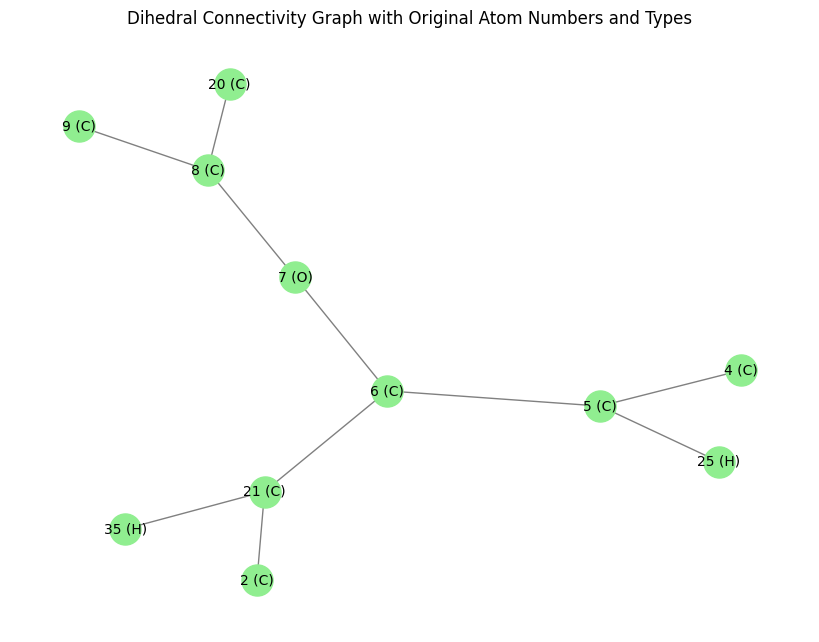

In [ ]:
# Adjust the label creation to ensure that the original atom indices from the dataframe are used
def create_graph_with_original_labels(df_proper_1_2):
    G = nx.Graph()  # Create an empty graph

    # Helper function to add edges and nodes from a dataframe
    def add_dihedral_edges(df):
        for _, row in df.iterrows():
            # Get the atom indices
            ai, aj, ak, al = row['ai'], row['aj'], row['ak'], row['al']
            atom_ai, atom_aj, atom_ak, atom_al = row['atom_ai'], row['atom_aj'], row['atom_ak'], row['atom_al']

            # Add nodes with their respective atom types and numbers as labels (keeping original indices)
            G.add_node(ai, label=f"{ai} ({atom_ai})")
            G.add_node(aj, label=f"{aj} ({atom_aj})")
            G.add_node(ak, label=f"{ak} ({atom_ak})")
            G.add_node(al, label=f"{al} ({atom_al})")

            # Add edges between the atoms
            G.add_edge(ai, aj)  # ai-aj
            G.add_edge(aj, ak)  # aj-ak
            G.add_edge(ak, al)  # ak-al

    # Add edges from both improper and proper dihedrals
    add_dihedral_edges(df_proper_1_2)

    return G

# Create the graph from df_improper_1_2 and df_proper_1_2 using the original atom numbers
G_1_2 = create_graph_with_original_labels(df_proper_1_2)

# Draw the graph with the original atom numbers and their types as labels
pos = nx.spring_layout(G_1_2)  # Define the layout of the graph
labels = nx.get_node_attributes(G_1_2, 'label')  # Get the labels with original atom numbers and types

plt.figure(figsize=(8, 6))  # Set the figure size
nx.draw(G_1_2, pos, with_labels=True, labels=labels, node_size=500, node_color="lightgreen", font_size=10, font_color="black", edge_color="gray")
plt.title("Dihedral Connectivity Graph with Original Atom Numbers and Types")
plt.show()

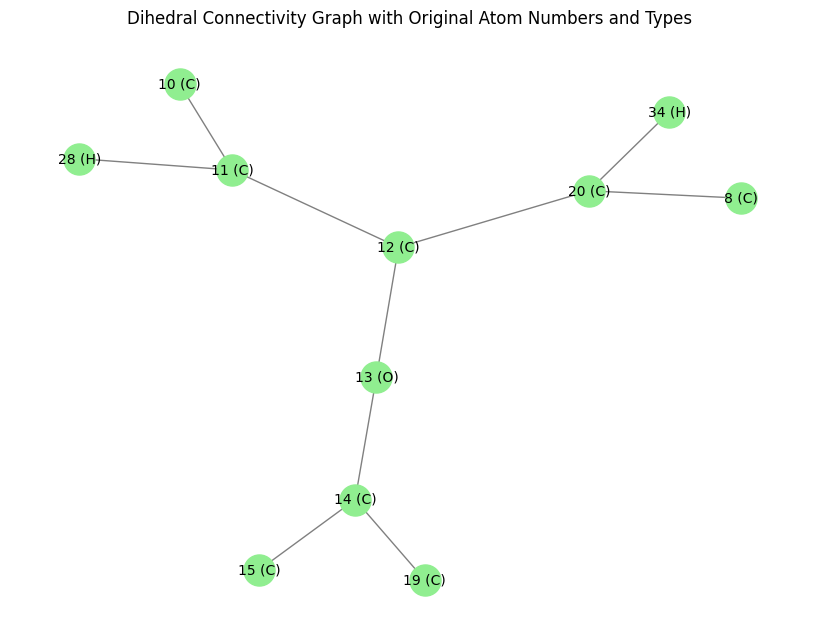

In [ ]:
# Adjust the label creation to ensure that the original atom indices from the dataframe are used
def create_graph_with_original_labels(df_proper_2_3):
    G = nx.Graph()  # Create an empty graph

    # Helper function to add edges and nodes from a dataframe
    def add_dihedral_edges(df):
        for _, row in df.iterrows():
            # Get the atom indices
            ai, aj, ak, al = row['ai'], row['aj'], row['ak'], row['al']
            atom_ai, atom_aj, atom_ak, atom_al = row['atom_ai'], row['atom_aj'], row['atom_ak'], row['atom_al']

            # Add nodes with their respective atom types and numbers as labels (keeping original indices)
            G.add_node(ai, label=f"{ai} ({atom_ai})")
            G.add_node(aj, label=f"{aj} ({atom_aj})")
            G.add_node(ak, label=f"{ak} ({atom_ak})")
            G.add_node(al, label=f"{al} ({atom_al})")

            # Add edges between the atoms
            G.add_edge(ai, aj)  # ai-aj
            G.add_edge(aj, ak)  # aj-ak
            G.add_edge(ak, al)  # ak-al

    # Add edges from both improper and proper dihedrals
    add_dihedral_edges(df_proper_2_3)

    return G

# Create the graph from df_improper_1_2 and df_proper_2_3 using the original atom numbers
G_2_3 = create_graph_with_original_labels(df_proper_2_3)

# Draw the graph with the original atom numbers and their types as labels
pos = nx.spring_layout(G_2_3)  # Define the layout of the graph
labels = nx.get_node_attributes(G_2_3, 'label')  # Get the labels with original atom numbers and types

plt.figure(figsize=(8, 6))  # Set the figure size
nx.draw(G_2_3, pos, with_labels=True, labels=labels, node_size=500, node_color="lightgreen", font_size=10, font_color="black", edge_color="gray")
plt.title("Dihedral Connectivity Graph with Original Atom Numbers and Types")
plt.show()

In [ ]:
# Create the connectivity_map dataframe with initial values
connectivity_map = pd.DataFrame({
    '1_2': dh1,
    '2_3': dh2
})

# Graph G1 (1_2) and G2 (2_3) should have been defined earlier. We'll now try to match them.
GM = isomorphism.GraphMatcher(G_1_2, G_2_3)

if GM.is_isomorphic():
    # If the graphs are isomorphic, get the node mapping and extend connectivity_map
    node_map = GM.mapping
    print("Graph isomorphism found. Mapping:")
    for key in node_map:
        print(f"{key} (from 1_2) -> {node_map[key]} (from 2_3)")

        # Add the mapping to the connectivity_map
        if key not in connectivity_map['1_2'].values:
            new_row = pd.DataFrame({'1_2': [key], '2_3': [node_map[key]]})
            connectivity_map = pd.concat([connectivity_map, new_row], ignore_index=True)

else:
    print("The graphs are not isomorphic.")

# Display the updated connectivity_map
print("\nUpdated connectivity_map after graph mapping:")
print(connectivity_map)

Graph isomorphism found. Mapping:
21 (from 1_2) -> 20 (from 2_3)
6 (from 1_2) -> 12 (from 2_3)
7 (from 1_2) -> 13 (from 2_3)
8 (from 1_2) -> 14 (from 2_3)
9 (from 1_2) -> 19 (from 2_3)
20 (from 1_2) -> 15 (from 2_3)
5 (from 1_2) -> 11 (from 2_3)
25 (from 1_2) -> 28 (from 2_3)
2 (from 1_2) -> 34 (from 2_3)
4 (from 1_2) -> 10 (from 2_3)
35 (from 1_2) -> 8 (from 2_3)

Updated connectivity_map after graph mapping:
    1_2  2_3
0    21   20
1     6   12
2     7   13
3     8   14
4     9   19
5    20   15
6     5   11
7    25   28
8     2   34
9     4   10
10   35    8


In [ ]:
# Step 1: Add nmer_1_2 by mapping the atom numbers in the '1_2' column to their corresponding 'nmer' in df_atoms
connectivity_map['nmer_1_2'] = connectivity_map['1_2'].map(df_atoms.set_index('nr')['nmer'])

# Step 2: Add nmer_2_3 by mapping the atom numbers in the '2_3' column to their corresponding 'nmer' in df_atoms
connectivity_map['nmer_2_3'] = connectivity_map['2_3'].map(df_atoms.set_index('nr')['nmer'])

# Step 3: Display the updated connectivity_map
print("\nUpdated connectivity_map with nmer_1_2 and nmer_2_3:")
print(connectivity_map)


Updated connectivity_map with nmer_1_2 and nmer_2_3:
    1_2  2_3  nmer_1_2  nmer_2_3
0    21   20         1         2
1     6   12         1         2
2     7   13         2         3
3     8   14         2         3
4     9   19         2         3
5    20   15         2         3
6     5   11         1         2
7    25   28         1         2
8     2   34         1         2
9     4   10         1         2
10   35    8         1         2


### Create Mid-Mid Connection Dataframes

In [ ]:
df_bonds_2_2 = df_bonds_1_2.copy()
df_angles_2_2 = df_angles_1_2.copy()
df_improper_2_2 = df_improper_1_2.copy()
df_proper_2_2 = df_proper_1_2.copy()

print(df_bonds_2_2)
print(df_angles_2_2)
print(df_improper_2_2)
print(df_proper_2_2)

   ai  aj funct      c0          c1  nmer_ai  nmer_aj atom_ai atom_aj
5   7   6     1  0.1364  376560.000        2        1       O       C
    ai  aj  ak funct       c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
4    5   6   7     1  120.000  585.760        1        1        2       C   
5    6   7   8     1  111.000  627.600        1        2        2       C   
55   7   6  21     1  120.000  585.760        2        1        1       O   

   atom_aj atom_ak  
4        C       O  
5        O       C  
55       C       C  
   ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
0  21   6   5   7     4  180.000  10.460  2        1        1        1   

   nmer_al atom_ai atom_aj atom_ak atom_al  
0        2       C       C       C       O  
    ai  aj  ak  al funct      c0     c1       c2      c3      c4     c5  \
26   9   8   7   6     3  12.552  0.000  -12.552  -0.000  -0.000  0.000   
27  20   8   7   6     3  12.552  0.000  -12.552  -0.000  -0.000  0.000   
28 

In [ ]:
def update_atom_indices(df, connectivity_map, nmer_columns, atom_columns):
    """
    Update atom indices in a dataframe based on connectivity_map.

    Parameters:
    - df: The dataframe containing the nmer and atom columns (e.g., df_bonds_2_2, df_angles_2_2).
    - connectivity_map: The mapping dataframe containing the '1_2' and '2_3' columns.
    - nmer_columns: The columns to check for nmer values (e.g., ['nmer_ai', 'nmer_aj', 'nmer_ak']).
    - atom_columns: The corresponding atom columns to update (e.g., ['ai', 'aj', 'ak']).
    """
    for nmer_col, atom_col in zip(nmer_columns, atom_columns):
        # Find rows where nmer is 1
        rows_to_update = df[df[nmer_col] == 1]

        # For each atom index in the selected rows, replace with corresponding value from connectivity_map
        for idx, row in rows_to_update.iterrows():
            atom_value = row[atom_col]  # Get the atom value (e.g., ai, aj, etc.)

            # Look up the atom value in connectivity_map['1_2'] and replace it with the corresponding value from '2_3'
            if atom_value in connectivity_map['1_2'].values:
                new_atom_value = connectivity_map.loc[connectivity_map['1_2'] == atom_value, '2_3'].values[0]
                df.at[idx, atom_col] = new_atom_value  # Update the atom value with the new value from 2_3

    return df

# Update each of the dataframes
df_bonds_2_2 = update_atom_indices(df_bonds_2_2, connectivity_map, ['nmer_ai', 'nmer_aj'], ['ai', 'aj'])
df_angles_2_2 = update_atom_indices(df_angles_2_2, connectivity_map, ['nmer_ai', 'nmer_aj', 'nmer_ak'], ['ai', 'aj', 'ak'])
df_improper_2_2 = update_atom_indices(df_improper_2_2, connectivity_map, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])
df_proper_2_2 = update_atom_indices(df_proper_2_2, connectivity_map, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])

print(df_bonds_1_2)

# Print the updated dataframes
print("\nUpdated df_bonds_2_2:")
print(df_bonds_2_2)

print("\nUpdated df_angles_2_2:")
print(df_angles_2_2)

print("\nUpdated df_improper_2_2:")
print(df_improper_2_2)

print("\nUpdated df_proper_2_2:")
print(df_proper_2_2)

   ai  aj funct      c0          c1  nmer_ai  nmer_aj atom_ai atom_aj
5   7   6     1  0.1364  376560.000        2        1       O       C

Updated df_bonds_2_2:
   ai  aj funct      c0          c1  nmer_ai  nmer_aj atom_ai atom_aj
5   7  12     1  0.1364  376560.000        2        1       O       C

Updated df_angles_2_2:
    ai  aj  ak funct       c0       c1  nmer_ai  nmer_aj  nmer_ak atom_ai  \
4   11  12   7     1  120.000  585.760        1        1        2       C   
5   12   7   8     1  111.000  627.600        1        2        2       C   
55   7  12  20     1  120.000  585.760        2        1        1       O   

   atom_aj atom_ak  
4        C       O  
5        O       C  
55       C       C  

Updated df_improper_2_2:
   ai  aj  ak  al funct       c0      c1 c2  nmer_ai  nmer_aj  nmer_ak  \
0  20  12  11   7     4  180.000  10.460  2        1        1        1   

   nmer_al atom_ai atom_aj atom_ak atom_al  
0        2       C       C       C       O  

Updated df_pro

Note that nmer=1 here is not related to the start unit, it is instead the first middle unit and nmer=2 is the second middle unit

## Build Extended .itp

In [ ]:
# Initialize final dataframes from df__start
df_atoms_fin = df_atoms_start.copy()
df_bonds_fin = df_bonds_start.copy()
df_angles_fin = df_angles_start.copy()
df_proper_fin = df_proper_start.copy()
df_improper_fin = df_improper_start.copy()

# Step 1: Append df_data_1_2 to final dataframes
df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_1_2], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_1_2], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_1_2], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_1_2], ignore_index=True)

# Add df_data_mid (add i to nmer values)
df_atoms_mid_copy = df_atoms_mid.copy()
df_atoms_mid_copy['nmer']
df_bonds_mid_copy = df_bonds_mid.copy()
df_bonds_mid_copy[['nmer_ai', 'nmer_aj']]
df_angles_mid_copy = df_angles_mid.copy()
df_angles_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']]
df_proper_mid_copy = df_proper_mid.copy()
df_proper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']]
df_improper_mid_copy = df_improper_mid.copy()
df_improper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']]

df_atoms_fin = pd.concat([df_atoms_fin, df_atoms_mid_copy], ignore_index=True)
df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_mid_copy], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_mid_copy], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_mid_copy], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_mid_copy], ignore_index=True)


# Step 2: Perform the loop n-2 times to append df_data_mid and df_data_2_2
for i in range(n - 3):

    # Add df_data_2_2 (add i+1 to nmer values)
    df_bonds_2_2_copy = df_bonds_2_2.copy()
    df_bonds_2_2_copy[['nmer_ai', 'nmer_aj']] += i + 1
    df_angles_2_2_copy = df_angles_2_2.copy()
    df_angles_2_2_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] += i + 1
    df_proper_2_2_copy = df_proper_2_2.copy()
    df_proper_2_2_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1
    df_improper_2_2_copy = df_improper_2_2.copy()
    df_improper_2_2_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1

    df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_2_2_copy], ignore_index=True)
    df_angles_fin = pd.concat([df_angles_fin, df_angles_2_2_copy], ignore_index=True)
    df_proper_fin = pd.concat([df_proper_fin, df_proper_2_2_copy], ignore_index=True)
    df_improper_fin = pd.concat([df_improper_fin, df_improper_2_2_copy], ignore_index=True)

    # Add df_data_mid (add i to nmer values)
    df_atoms_mid_copy = df_atoms_mid.copy()
    df_atoms_mid_copy['nmer'] += i + 1
    df_bonds_mid_copy = df_bonds_mid.copy()
    df_bonds_mid_copy[['nmer_ai', 'nmer_aj']] += i + 1
    df_angles_mid_copy = df_angles_mid.copy()
    df_angles_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] += i + 1
    df_proper_mid_copy = df_proper_mid.copy()
    df_proper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1
    df_improper_mid_copy = df_improper_mid.copy()
    df_improper_mid_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += i + 1

    df_atoms_fin = pd.concat([df_atoms_fin, df_atoms_mid_copy], ignore_index=True)
    df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_mid_copy], ignore_index=True)
    df_angles_fin = pd.concat([df_angles_fin, df_angles_mid_copy], ignore_index=True)
    df_proper_fin = pd.concat([df_proper_fin, df_proper_mid_copy], ignore_index=True)
    df_improper_fin = pd.concat([df_improper_fin, df_improper_mid_copy], ignore_index=True)

# Step 3: Add df_data_2_3 and adjust nmer values (add n-3 to nmer values)
df_bonds_2_3_copy = df_bonds_2_3.copy()
df_bonds_2_3_copy[['nmer_ai', 'nmer_aj']] += (n - 3)
df_angles_2_3_copy = df_angles_2_3.copy()
df_angles_2_3_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] += (n - 3)
df_proper_2_3_copy = df_proper_2_3.copy()
df_proper_2_3_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += (n - 3)
df_improper_2_3_copy = df_improper_2_3.copy()
df_improper_2_3_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] += (n - 3)

df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_2_3_copy], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_2_3_copy], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_2_3_copy], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_2_3_copy], ignore_index=True)

# Step 4: Add df_data_end and set nmer values to n
df_atoms_end_copy = df_atoms_end.copy()
df_atoms_end_copy['nmer'] = n
df_bonds_end_copy = df_bonds_end.copy()
df_bonds_end_copy[['nmer_ai', 'nmer_aj']] = n
df_angles_end_copy = df_angles_end.copy()
df_angles_end_copy[['nmer_ai', 'nmer_aj', 'nmer_ak']] = n
df_proper_end_copy = df_proper_end.copy()
df_proper_end_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] = n
df_improper_end_copy = df_improper_end.copy()
df_improper_end_copy[['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al']] = n

df_atoms_fin = pd.concat([df_atoms_fin, df_atoms_end_copy], ignore_index=True)
df_bonds_fin = pd.concat([df_bonds_fin, df_bonds_end_copy], ignore_index=True)
df_angles_fin = pd.concat([df_angles_fin, df_angles_end_copy], ignore_index=True)
df_proper_fin = pd.concat([df_proper_fin, df_proper_end_copy], ignore_index=True)
df_improper_fin = pd.concat([df_improper_fin, df_improper_end_copy], ignore_index=True)

# Final result with updated dataframes
print("\nFinal df_atoms:")
print(df_atoms_fin)
print("\nFinal df_bonds:")
print(df_bonds_fin)
print("\nFinal df_angles:")
print(df_angles_fin)
print("\nFinal df_proper:")
print(df_proper_fin)
print("\nFinal df_improper:")
print(df_improper_fin)



Final df_atoms:
     nr      type resnr residue atom cgnr   charge     mass  nmer atom_type  \
0     1  opls_800     1     UNK  O00    1  -0.4952  15.9990     1         O   
1     2  opls_801     1     UNK  C01    1   0.1661  12.0110     1         C   
2     3  opls_802     1     UNK  C02    1  -0.2764  12.0110     1         C   
3     4  opls_803     1     UNK  C03    1  -0.0744  12.0110     1         C   
4     5  opls_804     1     UNK  C04    1  -0.2100  12.0110     1         C   
..   ..       ...   ...     ...  ...  ...      ...      ...   ...       ...   
437  29  opls_828     1     UNK  H0T    1   0.1669   1.0080    40         H   
438  30  opls_829     1     UNK  H0U    1   0.1553   1.0080    40         H   
439  31  opls_830     1     UNK  H0V    1   0.1520   1.0080    40         H   
440  32  opls_831     1     UNK  H0W    1   0.1534   1.0080    40         H   
441  33  opls_832     1     UNK  H0X    2   0.1639   1.0080    40         H   

    atom_namnum  
0            00 

In [ ]:
def renumber_df(df, df_renumber, nmer_columns, atom_columns):
    """
    Renumber the atom indices in a dataframe using the df_renumber mapping.

    Parameters:
    - df: The dataframe containing atom and nmer columns (e.g., df_atoms_fin, df_bonds_fin).
    - df_renumber: The renumbering dataframe with 'nmer', 'nr_original', and 'nr_renumbered' columns.
    - nmer_columns: The nmer columns to check (e.g., ['nmer', 'nmer_ai', 'nmer_aj']).
    - atom_columns: The corresponding atom columns to renumber (e.g., ['nr', 'ai', 'aj']).
    """
    for nmer_col, atom_col in zip(nmer_columns, atom_columns):
        # Iterate through each row in the dataframe
        for idx, row in df.iterrows():
            nmer_value = row[nmer_col]  # Get the nmer value (e.g., nmer, nmer_ai, etc.)
            atom_value = row[atom_col]  # Get the atom value (e.g., nr, ai, etc.)

            # Find the corresponding row in df_renumber where nmer and nr_original match
            matching_row = df_renumber[
                (df_renumber['nmer'] == nmer_value) &
                (df_renumber['nr_original'] == atom_value)
            ]

            # Replace the atom value with nr_renumbered if a match is found
            if not matching_row.empty:
                new_atom_value = matching_row['nr_renumbered'].values[0]
                df.at[idx, atom_col] = new_atom_value

    return df

# Apply renumbering to each final dataframe
df_atoms_fin = renumber_df(df_atoms_fin, df_renumber, ['nmer'], ['nr'])
df_bonds_fin = renumber_df(df_bonds_fin, df_renumber, ['nmer_ai', 'nmer_aj'], ['ai', 'aj'])
df_angles_fin = renumber_df(df_angles_fin, df_renumber, ['nmer_ai', 'nmer_aj', 'nmer_ak'], ['ai', 'aj', 'ak'])
df_proper_fin = renumber_df(df_proper_fin, df_renumber, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])
df_improper_fin = renumber_df(df_improper_fin, df_renumber, ['nmer_ai', 'nmer_aj', 'nmer_ak', 'nmer_al'], ['ai', 'aj', 'ak', 'al'])

# Print updated final dataframes
print("\nUpdated df_atoms_fin:")
print(df_atoms_fin)

print("\nUpdated df_bonds_fin:")
print(df_bonds_fin)

print("\nUpdated df_angles_fin:")
print(df_angles_fin)

print("\nUpdated df_proper_fin:")
print(df_proper_fin)

print("\nUpdated df_improper_fin:")
print(df_improper_fin)


Updated df_atoms_fin:
      nr      type resnr residue atom cgnr   charge     mass  nmer atom_type  \
0      1  opls_800     1     UNK  O00    1  -0.4952  15.9990     1         O   
1      2  opls_801     1     UNK  C01    1   0.1661  12.0110     1         C   
2      4  opls_802     1     UNK  C02    1  -0.2764  12.0110     1         C   
3      6  opls_803     1     UNK  C03    1  -0.0744  12.0110     1         C   
4     10  opls_804     1     UNK  C04    1  -0.2100  12.0110     1         C   
..   ...       ...   ...     ...  ...  ...      ...      ...   ...       ...   
437  436  opls_828     1     UNK  H0T    1   0.1669   1.0080    40         H   
438  440  opls_829     1     UNK  H0U    1   0.1553   1.0080    40         H   
439  442  opls_830     1     UNK  H0V    1   0.1520   1.0080    40         H   
440  441  opls_831     1     UNK  H0W    1   0.1534   1.0080    40         H   
441  437  opls_832     1     UNK  H0X    2   0.1639   1.0080    40         H   

    atom_namnum 

## Fix Atom Names & Finalize Dataframes (INCLUDE CHARGES HERE NOT CODED YET)

In [ ]:
atomic_symbols = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

def split_atom_name(df):
    atom_col = []
    atom_namnum_col = []

    for atom_name in df['atom']:
        atom = None
        atom_namnum = None

        # Check if the atom name starts with an atomic symbol
        for symbol in atomic_symbols:
            if atom_name.startswith(symbol):
                # Check if there are additional characters after the atomic symbol
                if len(atom_name) > len(symbol):
                    next_char = atom_name[len(symbol)]
                    if next_char.isdigit() or (next_char.isalpha() and next_char.isupper()):
                        atom = symbol
                        atom_namnum = atom_name[len(symbol):]
                        break
                    elif next_char.isalpha() and next_char.islower():
                        # Check if the full atom name matches any atomic symbol
                        if atom_name in atomic_symbols:
                            atom = atom_name
                            break

        if atom is None:
            raise ValueError(f"Atomic symbol not found in atom_name: {atom_name}")

        atom_col.append(atom)
        atom_namnum_col.append(atom_namnum)

    df['atom_type'] = atom_col
    df['atom_namnum'] = atom_namnum_col

    return df

# Update the atom_nam and atom_namnum columns using a custom hex style
def hex_style_atom_type(index):
    """Generate hex-style atom type based on index."""
    hex_digits = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    base = len(hex_digits)
    result = ''
    index -= 1
    while index > 0:
        index, remainder = divmod(index, base)
        result = hex_digits[remainder] + result
    return result.zfill(3)  # Pad with zeros to ensure three characters

def update_dataframe_with_hex_style(df):
    # Update atom_num to be sequential starting from 1
    df['atom_num'] = range(1, len(df) + 1)

    # Create a custom sequence for atom_namnum using hex_style_atom_type function
    df['atom_namnum'] = [hex_style_atom_type(i) for i in range(1, len(df) + 1)]

    return df

# Call the function to split the atom_name column
df_atoms_fin = split_atom_name(df_atoms_fin)

# Call the function to update the dataframe with the custom sequence
df_atoms_fin = update_dataframe_with_hex_style(df_atoms_fin)
df_atoms_fin['atom'] = df_atoms_fin['atom_type'] + df_atoms_fin['atom_namnum']

# Print the updated dataframe
print(df_atoms_fin)

      nr      type resnr residue  atom cgnr   charge     mass  nmer atom_type  \
0      1  opls_800     1     UNK  O000    1  -0.4952  15.9990     1         O   
1      2  opls_801     1     UNK  C001    1   0.1661  12.0110     1         C   
2      4  opls_802     1     UNK  C002    1  -0.2764  12.0110     1         C   
3      6  opls_803     1     UNK  C003    1  -0.0744  12.0110     1         C   
4     10  opls_804     1     UNK  C004    1  -0.2100  12.0110     1         C   
..   ...       ...   ...     ...   ...  ...      ...      ...   ...       ...   
437  436  opls_828     1     UNK  H0C5    1   0.1669   1.0080    40         H   
438  440  opls_829     1     UNK  H0C6    1   0.1553   1.0080    40         H   
439  442  opls_830     1     UNK  H0C7    1   0.1520   1.0080    40         H   
440  441  opls_831     1     UNK  H0C8    1   0.1534   1.0080    40         H   
441  437  opls_832     1     UNK  H0C9    2   0.1639   1.0080    40         H   

    atom_namnum  atom_num  

## Create output.itp

In [ ]:
def remove_columns(df, columns_to_remove):
    df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

def format_atoms_df(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['nr']:>6}{row['type']:>11}{row['resnr']:>7}{row['residue']:>7}{row['atom']:>6}{row['cgnr']:>7}{row['charge']:>11}{row['mass']:>11}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_bonds_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>5}{row['aj']:>6}{row['funct']:>6}{row['c0']:>12}{row['c1']:>11}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_angles_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>5}{row['aj']:>6}{row['ak']:>6}{row['funct']:>6}{row['c0']:>11}{row['c1']:>11}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_improper_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>6}{row['aj']:>6}{row['ak']:>6}{row['al']:>6}{row['funct']:>5}{row['c0']:>15}{row['c1']:>11}{row['c2']:>6}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

def format_proper_str(df):
    formatted_lines = []
    for index, row in df.iterrows():
        formatted_line = f"{row['ai']:>5}{row['aj']:>5}{row['ak']:>5}{row['al']:>5}{row['funct']:>9}{row['c0']:>12}{row['c1']:>8}{row['c2']:>8}{row['c3']:>8}{row['c4']:>8}{row['c5']:>8}"
        formatted_lines.append(formatted_line)
    return '\n'.join(formatted_lines)

###############################################
# AFTER EXTENSION
###############################################
# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj",  "nmer_ak",  "nmer_al" ]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_proper_fin, columns_to_remove)
# Print the updated DataFrame
print(df_proper_fin)

# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj",  "nmer_ak",  "nmer_al" ]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_improper_fin, columns_to_remove)
# Print the updated DataFrame
print(df_improper_fin)

# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj",  "nmer_ak" ]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_angles_fin, columns_to_remove)
# Print the updated DataFrame
print(df_angles_fin)

# list of columns to remove
columns_to_remove = [ "nmer_ai",  "nmer_aj"]
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_bonds_fin, columns_to_remove)
# Print the updated DataFrame
print(df_bonds_fin)

# list of columns to remove
columns_to_remove = ['nmer']
# Call the function to remove the specified columns from the DataFrame
remove_columns(df_atoms_fin, columns_to_remove)
# Define the desired column order
desired_columns = ['nr', 'type', 'resnr', 'residue', 'atom', 'cgnr', 'charge', 'mass']
# Reorder the columns of df_atoms using reindex
df_atoms_fin = df_atoms_fin.reindex(columns=desired_columns)
# Print the rearranged DataFrame
print(df_atoms_fin)

# Convert the specified columns to strings with three decimal places
df_atoms_fin[['charge','mass']] = df_atoms_fin[['charge','mass']].astype(float)
df_bonds_fin[['c0', 'c1']] = df_bonds_fin[['c0', 'c1']].astype(float)
df_angles_fin[['c0', 'c1']] = df_angles_fin[['c0', 'c1']].astype(float)
df_improper_fin[['c0', 'c1']] = df_improper_fin[['c0', 'c1']].astype(float)
df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']] = df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']].astype(float)


df_atoms_fin[['charge','mass']] = df_atoms_fin[['charge','mass']].applymap(lambda x: f"{x:.4f}")
df_bonds_fin[['c0']] = df_bonds_fin[['c0']].applymap(lambda x: f"{x:.4f}")
df_bonds_fin[['c1']] = df_bonds_fin[['c1']].applymap(lambda x: f"{x:.3f}")
df_angles_fin[['c0', 'c1']] = df_angles_fin[['c0', 'c1']].applymap(lambda x: f"{x:.3f}")
df_improper_fin[['c0', 'c1']] = df_improper_fin[['c0', 'c1']].applymap(lambda x: f"{x:.3f}")
df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']] = df_proper_fin[['c0', 'c1', 'c2', 'c3', 'c4', 'c5']].applymap(lambda x: f"{x:.3f}")

# Define the input and output file paths
output_file_path = 'output.itp'

# Initialize an empty list to store the modified lines
modified_lines = []

# Flag to start clearing data after encountering the "[ atoms ]" section
clear_data = False

# Read the file line by line
with open(itp_file_path, 'r') as file:
    for line in file:
        # Check if the line is a header or comment
        if line.strip() == '' or line.strip().startswith(';') or line.strip().startswith('['):
            # Retain headers and comments
            modified_lines.append(line)

            # Check if the current line is the "[ atoms ]" section
            if '[ atoms ]' in line:
                clear_data = True
        else:
            # If clear_data is True, ignore data lines
            if clear_data:
                continue
            else:
                modified_lines.append(line)

# Remove lines containing the string "pair"
modified_lines = [line for line in modified_lines if 'pair' not in line]

# Write the modified content back to the file
with open(output_file_path, 'w') as file:
    file.writelines(modified_lines)

# Print a message indicating that the process is complete
print(f"Data has been cleared after '[ atoms ]', headers are retained, and lines containing 'pair' have been removed in {output_file_path}")

# Read the original file
with open('output.itp', 'r') as file:
    lines = file.readlines()

# Identify the line containing "[ bonds ]" and add a blank line before it
new_lines = []
for line in lines:
    if '[ bonds ]' in line:
        new_lines.append('\n')  # Add a blank line
        new_lines.append(line)  # Add the original line
    else:
        new_lines.append(line)  # Add the original line as is

# Write the modified content back to the file
with open('output.itp', 'w') as file:
    file.writelines(new_lines)

# Convert DataFrames to string format with correct spacing
atoms_str = format_atoms_df(df_atoms_fin)
bonds_str = format_bonds_str(df_bonds_fin)
angles_str = format_angles_str(df_angles_fin)
improper_str = format_improper_str(df_improper_fin)
proper_str = format_proper_str(df_proper_fin)

# Read the original file
with open('output.itp', 'r') as file:
    lines = file.readlines()

# Identify sections and insert DataFrame strings
new_lines = []
i = 0
while i < len(lines):
    line = lines[i]
    if '[ atoms ]' in line:
        print("Found [ atoms ] section")
        new_lines.append(line)
        i += 1
        # Skip header line
        new_lines.append(lines[i])
        i += 1
        # Insert formatted DataFrame
        new_lines.append(atoms_str + '\n')
    elif '[ bonds ]' in line:
        print("Found [ bonds ] section")
        new_lines.append(line)
        i += 1
        # Insert formatted DataFrame
        new_lines.append(bonds_str + '\n')
    elif '[ angles ]' in line:
        print("Found [ angles ] section")
        new_lines.append(line)
        i += 1
        # Skip header line
        new_lines.append(lines[i])
        i += 1
        # Insert formatted DataFrame
        new_lines.append(angles_str + '\n')
    elif 'IMPROPER' in line:
        print("Found IMPROPER section")
        new_lines.append(line)
        i += 1
        # Skip headers until a blank line or next section
        while i < len(lines) and lines[i].strip() != '' and not any(keyword in lines[i] for keyword in ['[', 'IMPROPER', 'PROPER']):
            new_lines.append(lines[i])
            i += 1
        # Insert formatted DataFrame
        new_lines.append(improper_str + '\n')
    elif 'PROPER' in line:
        print("Found PROPER section")
        new_lines.append(line)
        i += 1
        # Skip headers until a blank line or next section
        while i < len(lines) and lines[i].strip() != '' and not any(keyword in lines[i] for keyword in ['[', 'IMPROPER', 'PROPER']):
            new_lines.append(lines[i])
            i += 1
        # Insert formatted DataFrame
        new_lines.append(proper_str + '\n')
    else:
        new_lines.append(line)
    i += 1

# Write the modified content back to the file
with open('output.itp', 'w') as file:
    file.writelines(new_lines)

       ai   aj   ak   al funct      c0     c1       c2      c3      c4     c5  \
0      10    9    5    2     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
1       5    9   10    6     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
2       9    5    2    4     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
3       5    2    4    6     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
4       9   10    6    4     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
...   ...  ...  ...  ...   ...     ...    ...      ...     ...     ...    ...   
1113  440  435  433  436     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
1114  437  434  438  441     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
1115  442  439  435  440     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
1116  437  434  432  431     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   
1117  436  433  432  431     3  30.334  0.000  -30.334  -0.000  -0.000  0.000   

     atom_ai atom_aj atom_a

<ipython-input-54-33c7ab957699>:89: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_atoms_fin[['charge','mass']] = df_atoms_fin[['charge','mass']].applymap(lambda x: f"{x:.4f}")
<ipython-input-54-33c7ab957699>:90: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bonds_fin[['c0']] = df_bonds_fin[['c0']].applymap(lambda x: f"{x:.4f}")
<ipython-input-54-33c7ab957699>:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_bonds_fin[['c1']] = df_bonds_fin[['c1']].applymap(lambda x: f"{x:.3f}")
<ipython-input-54-33c7ab957699>:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_angles_fin[['c0', 'c1']] = df_angles_fin[['c0', 'c1']].applymap(lambda x: f"{x:.3f}")
<ipython-input-54-33c7ab957699>:93: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_improper_fin[['c0', 'c1']] = df_improper_fin[['c0', 'c1']].ap

Found [ atoms ] section
Found [ bonds ] section
Found [ angles ] section
Found IMPROPER section
Found PROPER section


# Old Code & Extra Stuff (Charge modification is here, maybe adapt from this to edit the above).

In [ ]:
# Edit the df_atoms_fin dataframe to make the cgnr column the same as the nmer column
df_atoms_fin['cgnr'] = df_atoms_fin['nmer']

# Print the updated dataframe to verify changes
print(df_atoms_fin)

     nr      type resnr residue atom  cgnr   charge     mass  nmer
0     1  opls_800     1     UNK  O00     1  -0.4952  15.9990     1
1     2  opls_801     1     UNK  C01     1   0.1661  12.0110     1
2     3  opls_802     1     UNK  C02     1  -0.2764  12.0110     1
3     4  opls_803     1     UNK  C03     1  -0.0744  12.0110     1
4     5  opls_804     1     UNK  C04     1  -0.2100  12.0110     1
5     6  opls_805     1     UNK  C05     1   0.1625  12.0110     1
20   21  opls_820     1     UNK  C0K     1  -0.2486  12.0110     1
21   22  opls_821     1     UNK  H0M     1   0.4310   1.0080     1
22   23  opls_822     1     UNK  H0N     1   0.1536   1.0080     1
23   24  opls_823     1     UNK  H0O     1   0.1586   1.0080     1
24   25  opls_824     1     UNK  H0P     1   0.1688   1.0080     1
34   35  opls_834     1     UNK  H0Z     1   0.1831   1.0080     1
6    36  opls_806     1     UNK  O06     2  -0.2457  15.9990     2
7    37  opls_807     1     UNK  C07     2   0.1379  12.0110  

In [ ]:
def add_charges_to_units(df_atoms_fin):
    while True:
        # Ask the user if they would like to add charges to a unit
        add_charges = input("Would you like to add charges to a unit? (y/n): ").strip().lower()

        if add_charges == 'n':
            break

        if add_charges == 'y':
            # Ask the user for the units they would like to add charge to
            units_input = input("Which unit(s) would you like to add charge to? (provide numbers separated by commas): ").strip()
            units = [int(unit) for unit in units_input.split(',')]

            # Ask the user for the name of the charges file
            charges_file_name = input("What is the name of the charges file? (don't include .txt): ").strip()
            charges_file_path = f"{charges_file_name}.txt"

            try:
                # Read the charges from the text file and convert to floats rounded to 4 decimal places
                with open(charges_file_path, 'r') as file:
                    charges = []
                    for line in file:
                        line = line.strip()
                        # Ignore lines with unexpected characters
                        try:
                            charge = round(float(line), 4)
                            charges.append(charge)
                        except ValueError:
                            print(f"Warning: Ignoring invalid line: '{line}'")

                for unit in units:
                    # Get the index for the specified unit
                    unit_indices = df_atoms_fin[df_atoms_fin['nmer'] == unit].index
                    num_atoms_in_unit = len(unit_indices)

                    # Check if the number of charges matches the number of atoms in the unit
                    if num_atoms_in_unit != len(charges):
                        print(f"Error: The number of charges provided ({len(charges)}) does not match the number of atoms ({num_atoms_in_unit}) in unit {unit}.")
                        continue

                    # Update the charges for the specified unit
                    for idx, charge in zip(unit_indices, charges):
                        df_atoms_fin.at[idx, 'charge'] = f"{charge:.4f}"

                print(f"Charges updated successfully for units: {', '.join(map(str, units))}")

            except FileNotFoundError:
                print(f"Error: The file {charges_file_path} was not found.")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")


# Call the function to add charges to units
add_charges_to_units(df_atoms_fin)

Would you like to add charges to a unit? (y/n): y
Which unit(s) would you like to add charge to? (provide numbers separated by commas): 2,3
What is the name of the charges file? (don't include .txt): charges1,3
Charges updated successfully for units: 2, 3
Would you like to add charges to a unit? (y/n): y
Which unit(s) would you like to add charge to? (provide numbers separated by commas): 1,4
What is the name of the charges file? (don't include .txt): charges1,3
Charges updated successfully for units: 1, 4
Would you like to add charges to a unit? (y/n): n
